### Preliminary Data Exploration
Author: catwong@ 12/27/2018

Env: Python 2 (no virtualenv)
Datasets:
- Regex, Learning with Latent Language (Andreas et. al) [https://github.com/jacobandreas/l3/tree/master/data]
- Spatial Navigation (Janner et. al)
[https://github.com/JannerM/spatial-reasoning]
- CLEVR-Humans (Johnson et. al) [https://cs.stanford.edu/people/jcjohns/iep/]

In [1]:
from preliminary.exploration_utils import *
from data.dataset_loading import *
%matplotlib inline 


## Datasets 

#### L3-Regex

l3_regex: dict with keys {train, test, val}; each list of dicts with keys:
- examples: actual I/O pairs.
- hint: the actual NLP examples.
- hints_aug: templated, augmented.
- re: the regex

In [4]:
l3_regex=load_l3(verbose=True)

l3_regex: 
train: 3000 tasks
val: 500 tasks
test: 500 tasks


#### Spatial Reasoning - Janner Version

To load up to max_train train maps and max_val val maps with mode = [ local | global ] instructions and annotations = [ human | synthetic ] descriptions, run:

~~~~
>>> import data
>>> train_data, val_data = data.load(mode, annotations, max_train, max_val)
>>> layouts, objects, rewards, terminal, instructions, values, goals = train_data
~~~~
Local: 1566 train, 399 test
Global

In [2]:
local_sr, global_sr = load_sr(verbose=True)


<Data> Loading local train environments with human annotations
<Data> Found 1566 annotations

<Data> Loading local test environments with human annotations
<Data> Found 399 annotations

<Data> Loading global train environments with human annotations
<Data> Found 1071 annotations

<Data> Loading global test environments with human annotations
<Data> Found 272 annotations
Found 1566 train instructions.
Found 399 test instructions.
Found 1071 train instructions.
Found 272 test instructions.


In [3]:
# POS tag
for dataset in (local_sr, global_sr):
    for split in ('train', 'test'):
        for i in range(len(dataset[split])):
            dataset[split][i]['pos']=pos_tag(dataset[split][i]['hints_aug'])


NameError: name 'pos_tag' is not defined

In [ ]:
sr_data = {
    'local' : local_sr,
    'global' : global_sr
}

In [101]:
with open('data/spatialreasoning/sr_tokenized.json', 'w') as fp:
    json.dump(sr_data, fp)

### CLEVR-Humans

Note: official paper preprocessing is available here. https://github.com/facebookresearch/clevr-iep/blob/master/TRAINING.md

Format: JSON files have keys ['info', 'questions']; questions is a list with format:
```
{u'answer': u'yes', u'question': u'Is there a blue cylinder?', u'split': u'train', u'image_index': 1429, u'image_filename': u'CLEVR_train_001429.png'}
```

In [6]:
clevr_humans = load_clevr_humans(verbose=True)

Found 17817 questions in train
Found 7145 questions in test
Found 7202 questions in val


In [7]:
TOP_LEVEL='/Users/catwong/mit/semantics/'
def load_clevr(verbose=False):
	import json
	questions="clevr_humans/questions/CLEVR_train_questions.json"
	questions=os.path.join(TOP_LEVEL, "data", questions)
	json_data = open(questions).read()
	return json.loads(json_data)
clevr = load_clevr(verbose=True)

### Misty Dataset
Reference: http://aclweb.org/anthology/D17-1015 


In [2]:
import json
with open('data/misty/mistyraw/misty_text.json') as f:
    misty_raw = json.load(f)
    print(len(misty_raw))

2572


In [3]:
def tokenize(s, delim=' ',
	      add_start_token=True, add_end_token=True,
	      punct_to_keep=[';', ','], punct_to_remove=['?', '.']):
	    """Taken from Johnson et. al"""
	    s = s.lower()
	    if punct_to_keep is not None:
	        for p in punct_to_keep:
	            s = s.replace(p, '%s%s' % (delim, p))
	    if punct_to_remove is not None:
	        for p in punct_to_remove:
	            s = s.replace(p, '')
	    tokens = s.split(delim)

	    return tokens
misty_preprocessed = [tokenize(text.lower()) for text in misty_raw]

In [6]:
misty = [{'instruction': " ".join(misty_preprocessed[i]), 'tokenized' : misty_preprocessed[i]} 
         for i in range(len(misty_raw))]

In [37]:
misty = [{'instruction': misty[i]['instruction'], 'tokenized' : word_tokenize(misty[i]['instruction'])} 
         for i in range(len(misty_raw))]

In [30]:
# Simple POS
import nltk
from nltk import pos_tag
from nltk import word_tokenize

In [39]:
misty = [{'instruction': misty[i]['instruction'], 
          'tokenized' : misty[i]['tokenized'],
         'pos' : pos_tag(misty[i]['tokenized'])} 
         for i in range(len(misty_raw))]


In [40]:
with open('data/misty/mistyraw/misty_tokenized.json', 'w') as fp:
    json.dump(misty, fp)

In [41]:
misty[0]['pos']

[(u'move', 'NN'),
 (u'left', 'VBD'),
 (u'half', 'JJ'),
 (u'way', 'NN'),
 (u'around', 'IN'),
 (u'the', 'DT'),
 (u'room', 'NN'),
 (u'to', 'TO'),
 (u'the', 'DT'),
 (u'corner', 'NN'),
 (u'there', 'EX'),
 (u'is', 'VBZ'),
 (u'a', 'DT'),
 (u'door', 'NN'),
 (u'misty', 'NN'),
 (u'is', 'VBZ'),
 (u'mid-way', 'RB'),
 (u'up', 'IN'),
 (u'the', 'DT'),
 (u'door', 'NN'),
 (u'in', 'IN'),
 (u'front', 'NN'),
 (u'of', 'IN'),
 (u'the', 'DT'),
 (u'door', 'NN')]

### Ground Truth Examples


In [6]:
## SR
## Spatial Reasoning (Janner)
def make_sr_dataset(raw_train, raw_test, verbose):
	sr_dataset = {'train': [], 'test': []}
	for i, dataset in enumerate((raw_train, raw_test)):
		layouts, objects, rewards, terminal, instructions, values, goals = dataset
		mode = 'train' if i == 0 else 'test'
		if verbose:
			print("Found %d %s instructions." % (len(instructions), mode))
		
		for instruction in instructions:
			sr_dataset[mode].append({
				'hints_aug': instruction.split()
			})
	return sr_dataset

def load_sr(verbose=False):
	"""
	Returns: local_sr, global_sr
	"""
	import data.spatialreasoning
	import data.spatialreasoning.environment
	import data.spatialreasoning.data as srdata
	
	annotations='human'
	n_local_train, n_local_val = 1500, 3000
	n_global_train, n_global_val = 50, 50
	data_path = os.path.join(TOP_LEVEL, "data", "spatialreasoning/data")
	local_train, local_val = srdata.load(data_path, 'local', annotations, n_local_train, n_local_val)
	global_train, global_val = srdata.load(data_path, 'global', annotations, n_global_train, n_global_val)
	return local_train, local_val, global_train, global_val		

local_train, local_val, global_train, global_val = load_sr()


<Data> Loading local train environments with human annotations
<Data> Found 1500 annotations

<Data> Loading local test environments with human annotations
<Data> Found 399 annotations

<Data> Loading global train environments with human annotations
<Data> Found 50 annotations

<Data> Loading global test environments with human annotations
<Data> Found 50 annotations


In [18]:
layouts, objects, rewards, terminal, instructions, values, goals = local_val
sorted_instructions = np.argsort([len(instruction) for instruction in instructions])

In [28]:
instructions


[u'house under the tree',
 u'reach cell that is one up from diamond',
 u'reach cell between horse .',
 u'reach rock cell to right of spade and directly above house .',
 u'to the left of the circle',
 u'reach the cell with the house immediately to the right of the rock .',
 u'cell one below heart',
 u'reach cell to the left of tree and above house',
 u'reach tree one above square , one above and right of heart .',
 u'reach the cell with the green diamond',
 u'move to square bottom left of heart',
 u'reach house next to tree',
 u'reach cell with house to right of circle and below rock',
 u'reach rock one above triangle and six above circle .',
 u'reach cell with the hea',
 u'move to the square two below and one left of the star',
 u'move one cell to the left of spade .',
 u'reach tree under rock',
 u'reach the cell with the house to the left of the spade',
 u'cell obe below circle',
 u'reach the cell one up from between the tree and the orange triangle',
 u'reach the empty cell that is t

reach cell one left of orange triangle
(8, 2)


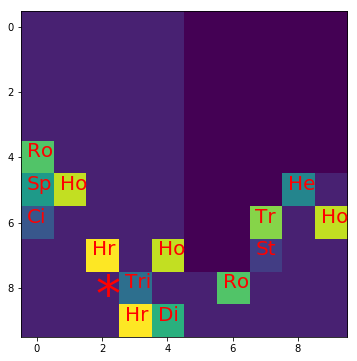

three squares to the right of the tree
(2, 9)


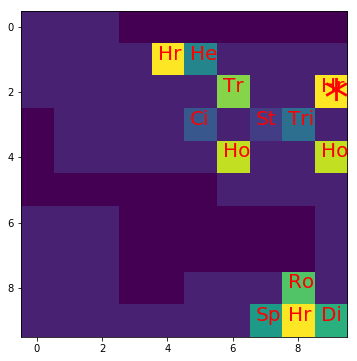

reach cell directly above green diamond
(6, 8)


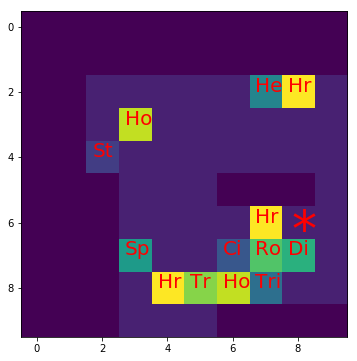

reach horse to the bottom left of heart
(3, 8)


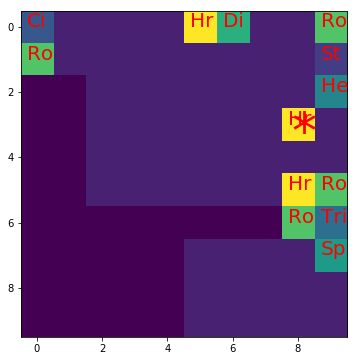

reach one cell to left and below rock .
(1, 5)


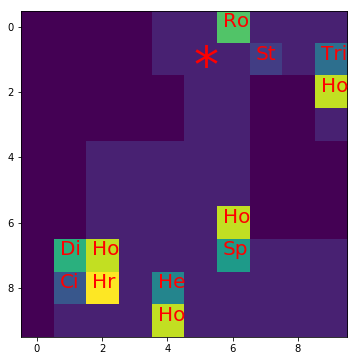

reach the cell to the right of the star
(9, 3)


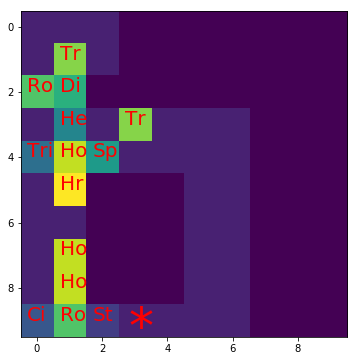

reach cell that is rock one below spade
(3, 5)


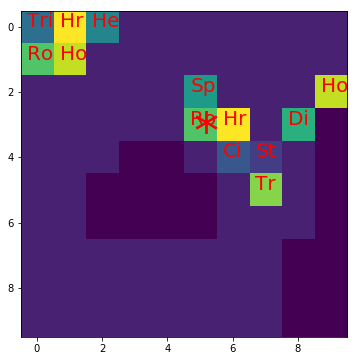

reach cell directly below green diamond
(8, 8)


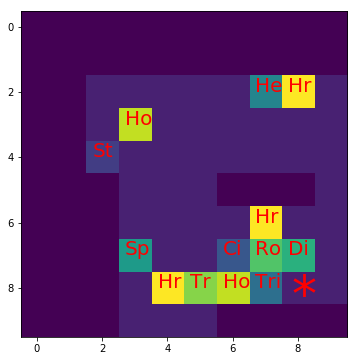

reach the house below the green diamond
(3, 6)


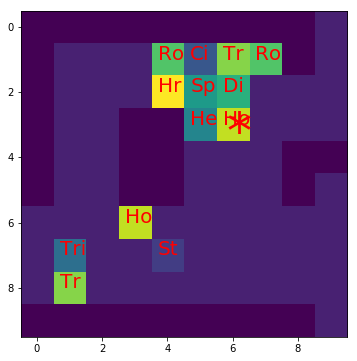

reach goal that is bottom left of heart
(3, 6)


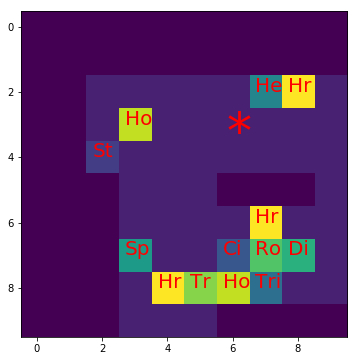

reach cell one directly above the spade
(6, 3)


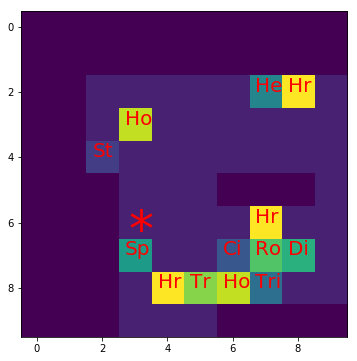

reach cell that is rock one below spade
(3, 5)


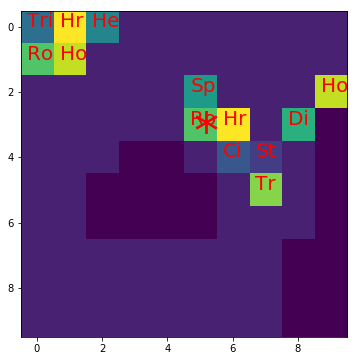

move to horse cell directly below spade
(2, 3)


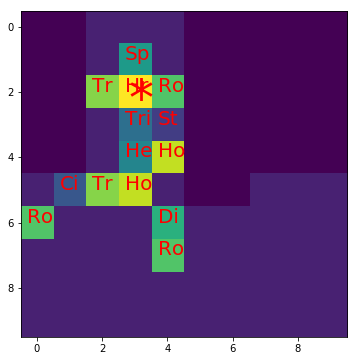

reach the horse to the left of the heart
(1, 4)


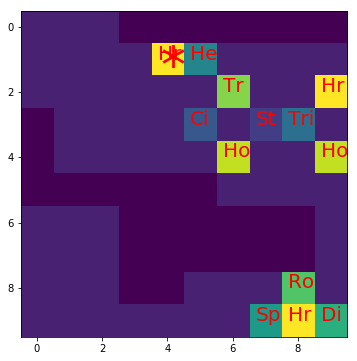

reach heart bellow the orange triangle .
(4, 3)


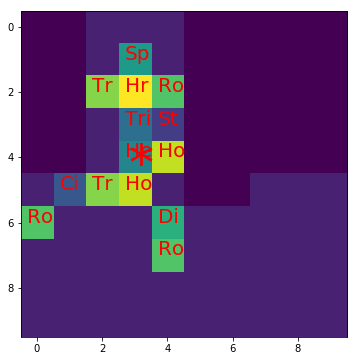

reach cell to the right of the diamond .
(9, 5)


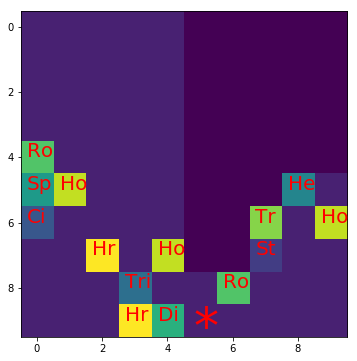

reach the square under the blue circle .
(7, 5)


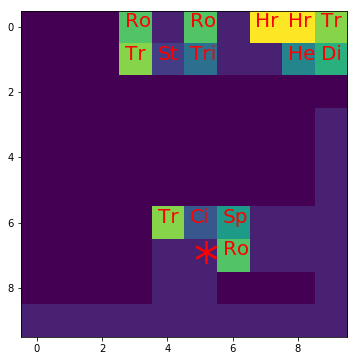

reach the cell to the right of the heart
(0, 3)


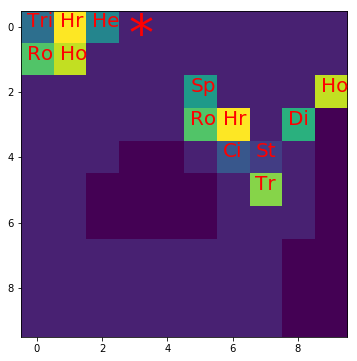

move to the square three above the horse
(5, 2)


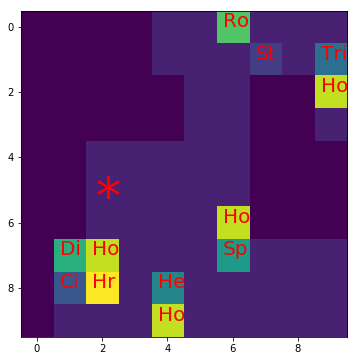

two above star five to the left of heart
(2, 2)


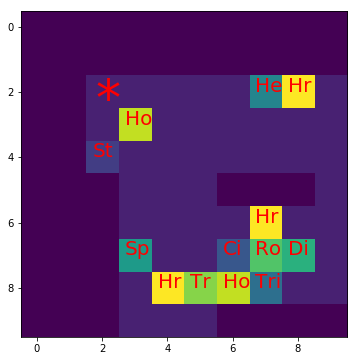

In [26]:
# Get all the layouts
def show_layouts(dataset, inds):
    for j in inds:
        layouts, objects, rewards, terminal, instructions, values, goals = dataset
        print instructions[j]
        print goals[j]
        from matplotlib import pyplot as plt
        plt.figure(figsize=(6,6))
        plt.imshow(objects[j].squeeze()+layouts[j].squeeze())
        def obj2text(obj, end):
            obj_strs = ['P', "St", "Ci", "Tri", "He", "Sp", "Di", "Ro", "Tr", "Ho", "Hr"]
            for i in range(len(obj)):
                for j in range(len(obj)):
                    if obj[i][j] != 0:
                        plt.text(j-0.3, i, obj_strs[int(obj[i][j])], fontsize=20,color="red")
            plt.text(end[1]-0.2, end[0]+0.7, "*", fontsize=50,color="red")
        obj2text(objects[j].squeeze(), goals[j])
        plt.show()
# Sort dataset by length of instructions
show_layouts(local_val, sorted_instructions[200:220])

In [148]:
## Regexes
def show_regexes(dataset, inds):
    for j in inds:
        print(" ".join(dataset[j]['hint']))
        print(dataset[j]['re'])
        print(dataset[j]['examples'])
       
        
show_regexes(l3_regex['train'], [1])


< replace consonants with j p >
<()(C)()@jp>
[[u'<pompadours>', u'<jpojpjpajpoujpjp>'], [u'<punched>', u'<jpujpjpjpejp>'], [u'<recriminations>', u'<jpejpjpijpijpajpiojpjp>'], [u'<agglutination>', u'<ajpjpjpujpijpajpiojp>'], [u'<interfacing>', u'<ijpjpejpjpajpijpjp>'], [u'<salaam>', u'<jpajpaajp>'], [u'<optimum>', u'<ojpjpijpujp>'], [u'<portraiture>', u'<jpojpjpjpaijpujpe>'], [u'<stabilizing>', u'<jpjpajpijpijpijpjp>'], [u'<topazes>', u'<jpojpajpejp>'], [u'<abettors>', u'<ajpejpjpojpjp>'], [u'<pleasantries>', u'<jpjpeajpajpjpjpiejp>'], [u'<exalt>', u'<ejpajpjp>'], [u'<what>', u'<jpjpajp>'], [u'<grant>', u'<jpjpajpjp>'], [u'<parted>', u'<jpajpjpejp>'], [u'<betokened>', u'<jpejpojpejpejp>'], [u'<yell>', u'<jpejpjp>'], [u'<departure>', u'<jpejpajpjpujpe>'], [u'<febrile>', u'<jpejpjpijpe>'], [u'<schoolmates>', u'<jpjpjpoojpjpajpejp>'], [u'<unearned>', u'<ujpeajpjpejp>'], [u'<sacs>', u'<jpajpjp>'], [u'<gnaws>', u'<jpjpajpjp>'], [u'<value>', u'<jpajpue>'], [u'<tried>', u'<jpjpiejp>'], [u'<gum

In [170]:
## CLEVR-Humans
def show_clevr_humans(dataset, inds):
    for j in inds:
        print("Human: " + dataset[j]['question'])
        print("Answer: "+ dataset[j]['answer'])
        # Get the CLEVR programs and original.
show_clevr_humans(clevr_humans['train'],[0])

Human: Is there a blue cylinder?
Answer: yes


In [177]:
## CLEVR
def show_clevr(dataset, inds):
    for j in inds:
        print("Question: " + dataset[j]['question'])
        print("Answer: " + dataset[j]['answer'])
        print("Program:")
        for line in dataset[j]['program']:
            print line 

show_clevr(clevr['questions'], [0])

Question: Are there more big green things than large purple shiny cubes?
Answer: yes
Program:
{u'function': u'scene', u'inputs': [], u'value_inputs': []}
{u'function': u'filter_size', u'inputs': [0], u'value_inputs': [u'large']}
{u'function': u'filter_color', u'inputs': [1], u'value_inputs': [u'green']}
{u'function': u'count', u'inputs': [2], u'value_inputs': []}
{u'function': u'scene', u'inputs': [], u'value_inputs': []}
{u'function': u'filter_size', u'inputs': [4], u'value_inputs': [u'large']}
{u'function': u'filter_color', u'inputs': [5], u'value_inputs': [u'purple']}
{u'function': u'filter_material', u'inputs': [6], u'value_inputs': [u'metal']}
{u'function': u'filter_shape', u'inputs': [7], u'value_inputs': [u'cube']}
{u'function': u'count', u'inputs': [8], u'value_inputs': []}
{u'function': u'greater_than', u'inputs': [3, 9], u'value_inputs': []}


In [164]:
# CLEVR-Humans
def show_clevr_humans(dataset, inds):
    for j in inds:
        print(dataset[j]['question'])
        print("Answer: "+dataset[j]['answer'])
        print(dataset[j]['image_filename'])
        
        

show_clevr_humans(clevr_humans['train'], [0])

Is there a blue cylinder?
Answer: yes
CLEVR_train_001429.png


#### Spatial Reasoning (Janner) and CLEVR-Humans

In [60]:
print("Spatial Reasoning Local and CLEVR-Humans")
local_sr_fdist = ngram_dataset_freq(local_sr['train'], 'hints_aug', verbose=False)
clevr_fdist = ngram_dataset_freq(clevr_humans['train'], 'tokenized', verbose=False)
_ = ngram_cross_dataset_freq([local_sr_fdist, clevr_fdist], verbose=True)

local_sr_fdist = ngram_dataset_freq(local_sr['train'], 'hints_aug', n=2, verbose=False)
clevr_fdist = ngram_dataset_freq(clevr_humans['train'], 'tokenized', n=2, verbose=False)
_ = ngram_cross_dataset_freq([local_sr_fdist, clevr_fdist], verbose=True)

Spatial Reasoning Local and CLEVR-Humans
Cross dataset frequency for 2 datasets.
Original vocabulary sizes are [196, 990]
Combined vocabulary size is 1069; intersected vocab is: 117
Intersection ngrams with freq > 10: 89
50 most common: (not including letters): [((u'the',), 22085), ((u'is',), 9786), ((u'are',), 8745), ((u'of',), 5785), ((u'object',), 3830), ((u'same',), 2565), ((u'to',), 2070), ((u'in',), 1995), ((u'that',), 1555), ((u'and',), 1540), ((u'a',), 1437), ((u'red',), 1270), ((u'blue',), 1229), ((u'purple',), 1216), ((u'green',), 1207), ((u'left',), 1168), ((u'two',), 1065), ((u'right',), 1042), ((u'yellow',), 910), ((u'one',), 780), ((u',',), 639), ((u'brown',), 470), ((u'on',), 456), ((u'other',), 456), ((u'most',), 396), ((u'square',), 395), ((u'above',), 390), ((u'from',), 375), ((u'which',), 344), ((u'between',), 339), ((u'with',), 293), ((u'next',), 276), ((u'by',), 274), ((u'closest',), 269), ((u'circle',), 255), ((u'it',), 251), ((u'diamond',), 230), ((u'gold',), 223

In [63]:
print("Spatial Reasoning Global and CLEVR-Humans")
global_sr_fdist = ngram_dataset_freq(global_sr['train'], 'hints_aug', verbose=False)
clevr_fdist = ngram_dataset_freq(clevr_humans['train'], 'tokenized', verbose=False)
_ = ngram_cross_dataset_freq([global_sr_fdist, clevr_fdist], verbose=True)

global_sr_fdist = ngram_dataset_freq(global_sr['train'], 'hints_aug', n=2, verbose=False)
clevr_fdist = ngram_dataset_freq(clevr_humans['train'], 'tokenized', n=2, verbose=False)
_ = ngram_cross_dataset_freq([global_sr_fdist, clevr_fdist], verbose=True)

Spatial Reasoning Global and CLEVR-Humans
Cross dataset frequency for 2 datasets.
Original vocabulary sizes are [191, 990]
Combined vocabulary size is 1079; intersected vocab is: 102
Intersection ngrams with freq > 10: 81
50 most common: (not including letters): [((u'the',), 21904), ((u'is',), 9719), ((u'of',), 5509), ((u'object',), 3833), ((u'same',), 2565), ((u'to',), 2187), ((u'in',), 1984), ((u'that',), 1478), ((u'a',), 1411), ((u'as',), 1279), ((u'red',), 1259), ((u'and',), 1123), ((u'all',), 1082), ((u'left',), 969), ((u'right',), 881), ((u'two',), 873), ((u'most',), 667), ((u',',), 614), ((u'or',), 597), ((u'items',), 591), ((u'one',), 532), ((u'on',), 460), ((u'other',), 458), ((u'go',), 426), ((u'square',), 408), ((u'which',), 344), ((u'farthest',), 324), ((u'only',), 311), ((u'from',), 293), ((u'between',), 266), ((u'closest',), 266), ((u'next',), 255), ((u'it',), 245), ((u'move',), 228), ((u'both',), 214), ((u'above',), 196), ((u'with',), 189), ((u'furthest',), 184), ((u'blo

## Within Domain Frequency Analyses

In [14]:
# Frequency Distributions

# # L3 Regex
# print("L3 Regex Frequency Distribution")
# train_hint = ngram_dataset_freq(l3_regex['train'], 'hints_aug', verbose=True)
# test_hint = ngram_dataset_freq(l3_regex['test'], 'hints_aug', verbose=True)

# train_hint = ngram_dataset_freq(l3_regex['train'], 'hints_aug', n=2, verbose=True)
# test_hint = ngram_dataset_freq(l3_regex['test'], 'hints_aug', n=2, verbose=True)

# SR
print("SR Frequency Distribution")
print ("LOCAL:")
_= ngram_dataset_freq(local_sr['train'], 'hints_aug', verbose=True, top_n=None)
_= ngram_dataset_freq(local_sr['test'], 'hints_aug', verbose=True, top_n=None)

_= ngram_dataset_freq(local_sr['train'], 'hints_aug', n=2, verbose=True, top_n=None)
_= ngram_dataset_freq(local_sr['test'], 'hints_aug', n=2, verbose=True, top_n=None)

print ("\nGLOBAL:")
_= ngram_dataset_freq(global_sr['train'], 'hints_aug', verbose=True, top_n=None)
_= ngram_dataset_freq(global_sr['test'], 'hints_aug', verbose=True, top_n=None)
_= ngram_dataset_freq(global_sr['train'], 'hints_aug', n=2, verbose=True, top_n=None)
_= ngram_dataset_freq(global_sr['test'], 'hints_aug', n=2, verbose=True, top_n=None)

# # CLEVR
# print("CLEVR_HUMANS Frequency Distribution")
# print("TRAIN")
# _= ngram_dataset_freq(clevr_humans['train'], 'tokenized', verbose=True)
# _= ngram_dataset_freq(clevr_humans['train'], 'tokenized', n=2, verbose=True)


SR Frequency Distribution
LOCAL:
Printing for ngram, n=1
Num descriptions: 1566
Description avg: 8, med: 8, min: 2, max: 24
Vocabulary size: 196
Ngrams with freq > 10: 62
Total ngram in corpus: 12757
50 most common: (not including letters): [((u'the',), 1780), ((u'reach',), 1082), ((u'cell',), 805), ((u'of',), 695), ((u'to',), 684), ((u'one',), 492), ((u'left',), 450), ((u'and',), 440), ((u'above',), 369), ((u'right',), 350), ((u'below',), 325), ((u'heart',), 254), ((u'house',), 248), ((u'tree',), 240), ((u'circle',), 235), ((u'spade',), 231), ((u'two',), 230), ((u'diamond',), 229), ((u'rock',), 217), ((u'horse',), 209), ((u'triangle',), 190), ((u'star',), 189), ((u'space',), 163), ((u'square',), 145), ((u'with',), 135), ((u'is',), 118), ((u'that',), 113), ((u'go',), 104), ((u'from',), 97), ((u'between',), 81), ((u'spaces',), 71), ((u'move',), 70), ((u'blue',), 70), ((u'down',), 66), ((u'up',), 63), ((u'cells',), 39), ((u'directly',), 39), ((u'green',), 34), ((u'purple',), 34), ((u'und

50 most common: (not including letters): [((u'the',), 335), ((u'to',), 193), ((u'cell',), 125), ((u'go',), 105), ((u'of',), 90), ((u'house',), 82), ((u'horse',), 76), ((u'move',), 69), ((u'tree',), 68), ((u'left',), 67), ((u'topmost',), 61), ((u'one',), 60), ((u'rock',), 48), ((u'most',), 46), ((u'reach',), 45), ((u'above',), 45), ((u'right',), 44), ((u'square',), 29), ((u'bottom',), 26), ((u'below',), 26), ((u'from',), 20), ((u'two',), 19), ((u'southernmost',), 19), ((u'easternmost',), 16), ((u'top',), 15), ((u'westernmost',), 14), ((u'bottommost',), 14), ((u'leftmost',), 14), ((u'and',), 11), ((u'rightmost',), 10), ((u'cells',), 10), ((u'with',), 8), ((u'eastmost',), 7), ((u'corner',), 6), ((u'between',), 6), ((u'down',), 6), ((u'up',), 6), ((u'highlight',), 5), ((u'northmost',), 5), ((u'on',), 5), ((u'southern',), 5), ((u'eastern',), 4), ((u'in',), 4), ((u'northernmost',), 4), ((u'directly',), 4), ((u'middle',), 4), ((u'spaces',), 4), ((u'west',), 4), ((u'uppermost',), 4), ((u'at',)

In [17]:
def ngram_cross_dataset_freq(fdists, verbose=False, top_n=50):
    """Frequency distributions intersected across several fdists from disparate datasets."""
    summed_fdist = Counter()
    for fdist in fdists:
        summed_fdist += fdist
        
    # Only get the intersecting vocabulary
    intersect_vocab = set.intersection(*[set(fdist.keys()) for fdist in fdists])
    intersected_fdist=Counter()
    for vocab in intersect_vocab:
        intersected_fdist[vocab] = summed_fdist[vocab]
    
    if verbose:
        common_ngrams = intersected_fdist.most_common(top_n)
        print("Cross dataset frequency for %d datasets." % len(fdists))
        print("Original vocabulary sizes are %s" % str([len(fdist) for fdist in fdists]))
        print("Combined vocabulary size is %d; intersected vocab is: %d" %(len(summed_fdist), len(intersect_vocab)))
        
        print("Intersection ngrams with freq > 10: %d" % len([word for word in intersected_fdist if intersected_fdist[word] > 10]))
        print("50 most common: (not including letters): " + str(common_ngrams))
    return intersected_fdist

In [18]:
# Misty
_= ngram_dataset_freq(misty, 'tokenized', verbose=True, top_n=None)
_= ngram_dataset_freq(misty, 'tokenized', n=2, verbose=True, top_n=None)


Printing for ngram, n=1
Num descriptions: 2572
Description avg: 18, med: 16, min: 6, max: 95
Vocabulary size: 1055
Ngrams with freq > 10: 265
Total ngram in corpus: 47071
50 most common: (not including letters): [((u'the',), 7327), ((u'is',), 3487), ((u'misty',), 2419), ((u'of',), 1902), ((u'on',), 1418), ((u'to',), 1352), ((u'in',), 1207), ((u'wall',), 923), ((u'and',), 894), ((u'near',), 853), ((u'door',), 746), ((u'right',), 652), ((u'floor',), 642), ((u'left',), 623), ((u'side',), 549), ((u'it',), 476), ((u'room',), 462), ((u'she',), 454), ((u'corner',), 406), ((u'front',), 385), ((u'table',), 359), ((u'bed',), 337), ((u'floating',), 304), ((u'that',), 279), ((u'between',), 267), ((u'from',), 266), ((u'with',), 264), ((u'there',), 264), ((u'shelf',), 261), ((u'next',), 260), ((u'wooden',), 252), ((u'above',), 245), ((u'window',), 238), ((u'facing',), 226), ((u'at',), 224), ((u'brown',), 223), ((u'pole',), 220), ((u'plant',), 212), ((u'you',), 212), ((u'top',), 205), ((u'block',), 1

In [19]:
print("Misty and Spatial Reasoning")
local_sr_fdist = ngram_dataset_freq(local_sr['train'], 'hints_aug', verbose=False)
misty_fdist = ngram_dataset_freq(misty, 'tokenized', verbose=False)
_ = ngram_cross_dataset_freq([local_sr_fdist, misty_fdist], verbose=True, top_n=None)

local_sr_fdist = ngram_dataset_freq(local_sr['train'], 'hints_aug', n=2, verbose=False)
misty_fdist = ngram_dataset_freq(misty, 'tokenized', n=2, verbose=False)
_ = ngram_cross_dataset_freq([local_sr_fdist, misty_fdist], verbose=True, top_n=None)

Misty and Spatial Reasoning
Cross dataset frequency for 2 datasets.
Original vocabulary sizes are [196, 1055]
Combined vocabulary size is 1124; intersected vocab is: 127
Intersection ngrams with freq > 10: 92
50 most common: (not including letters): [((u'the',), 9107), ((u'is',), 3605), ((u'of',), 2597), ((u'to',), 2036), ((u'on',), 1442), ((u'and',), 1334), ((u'in',), 1232), ((u'reach',), 1087), ((u'left',), 1073), ((u'right',), 1002), ((u',',), 872), ((u'a',), 864), ((u'near',), 860), ((u'above',), 614), ((u'one',), 592), ((u'side',), 552), ((u'it',), 483), ((u'corner',), 414), ((u'below',), 409), ((u'with',), 399), ((u'that',), 392), ((u'from',), 363), ((u'two',), 357), ((u'between',), 348), ((u'next',), 288), ((u'house',), 251), ((u'tree',), 243), ((u'at',), 231), ((u'square',), 231), ((u'brown',), 228), ((u'top',), 227), ((u'rock',), 220), ((u'you',), 213), ((u'block',), 203), ((u'located',), 188), ((u'box',), 185), ((u'which',), 182), ((u'space',), 169), ((u'middle',), 165), ((u'

In [61]:
print("Misty and Spatial Reasoning, skip-grams")
global_sr_fdist = ngram_dataset_freq(global_sr['train'], 'hints_aug', verbose=False, skip=True)
misty_fdist = ngram_dataset_freq(misty, 'tokenized', verbose=False, skip=True)
_ = ngram_cross_dataset_freq([global_sr_fdist, misty_fdist], verbose=True, top_n=None)


Misty and Spatial Reasoning, skip-grams
Cross dataset frequency for 2 datasets.
Original vocabulary sizes are [963, 7975]
Combined vocabulary size is 8712; intersected vocab is: 226
Intersection ngrams with freq > 10: 114
50 most common: (not including letters): [((u'is', '*', u'the'), 1306), ((u'the', '*', u'of'), 1072), ((u'the', '*', u'and'), 439), ((u'to', '*', u'left'), 362), ((u'left', '*', u'the'), 341), ((u'to', '*', u'right'), 316), ((u'the', '*', u'side'), 315), ((u'side', '*', u'the'), 304), ((u'right', '*', u'the'), 303), ((u'go', '*', u'the'), 299), ((u'is', '*', u'to'), 298), ((u'next', '*', u'the'), 200), ((u'the', '*', u'most'), 189), ((u'the', '*', u'on'), 188), ((u'the', '*', u'that'), 177), ((u'the', '*', u'to'), 172), ((u'left', '*', u'of'), 159), ((u'the', '*', u'with'), 151), ((u'right', '*', u'of'), 145), ((u'on', '*', u'left'), 144), ((u'the', '*', u'in'), 143), ((u'square', '*', u'the'), 140), ((u'middle', '*', u'the'), 139), ((u'the', '*', u'rock'), 136), ((u'

In [106]:
# Prototyping:

from collections import Counter
import numpy as np
import random

def ngram_dataset_freq(dataset, key, n=1, pos_n=None, verbose=False, top_n=50, skip=False, skip_pos=False):
    """Frequency distribution of ngrams across the entire dataset.
     Skip: Skip grams,
     """
    fdist = Counter()
    num_descriptions = 0
    lens = []
    diversity = []
    untokenized = []
    
    for example in dataset:
        descriptions = []
        if isinstance(example[key][0], list):
            for description in example[key]:
                if description[0] == '<': # Remove start/end tokens
                    start, end = 1, -1
                else:
                    start, end = 0, len(description)
                descriptions += [description[start:end]]

        else:
            description = example[key]
            if description[0] == '<': # Remove start/end tokens
                start, end = 1, -1
            else:
                start, end = 0, len(description)
            descriptions += [description[start:end]]
        
        # n-grams on a per-example basis
        fdist_in_task = Counter()
        for description in descriptions:
            steps = n + 2 if skip else n
            if pos_n and pos_n > n:
                steps = pos_n + 2 if skip_pos else pos_n
            if len(description) > 0:
                for i in range(len(description) - steps + 1):
                    if pos_n is not None:
                        token_ngram = tuple([x[0] for x in description[i:i+n]]) if not skip else tuple([description[i][0]] + ["*"]*n + [description[i+n+1][0]])
                        pos_ngram = tuple([x[1] for x in description[i:i+pos_n]])
                        ngram = (token_ngram, pos_ngram)
                    elif skip:
                        ngram = tuple([description[i]] + ["*"]*n +[description[i+n+1]])
                    else:
                        ngram = tuple(description[i:i+n])   
                    fdist[ngram] += 1
                    fdist_in_task[ngram] += 1
                lens.append(len(description))
                num_descriptions += len(descriptions)
                if pos_n is None:
                    untokenized.append(" ".join(description))
        if len(descriptions) > 1:
            diversity.append(float(len(fdist_in_task)) / np.sum(list(fdist_in_task.values())))
                
    if verbose:
        if top_n:
            common_ngrams = [(word, num) for (word, num) in fdist.most_common(100) if (len(word) > 1 or len(word[0]) > 1 )][:top_n]
        else:
            common_ngrams = [(word, num) for (word, num) in fdist.most_common() if (len(word) > 1 or len(word[0]) > 1 )]
        
        print("Printing for ngram, n=%d" % n)
        print("Num descriptions: %d" % num_descriptions)
        print("Description avg: %d, med: %d, min: %d, max: %d" % (np.mean(lens), np.median(lens), np.min(lens), np.max(lens)))
        if len(diversity) > 1:
            print("Ngram diversity within tasks w. multiple examples: avg: %f, med: %f, min: %f, max: %d " % (np.mean(diversity), np.median(diversity), np.min(diversity), np.max(diversity)))
        print("Vocabulary size: %d" % len(fdist) )
        print("Ngrams with freq > 10: %d" % len([word for word in fdist if fdist[word] > 10]))
        print("Total ngram in corpus: %d" % np.sum(list(fdist.values())))
        print("50 most common: (not including letters): " + str(common_ngrams))
        if pos_n is None:
            print("Sample descriptions: ")
            rand = random.sample(untokenized, 5)
            for description in rand:
                print(description)
        
    return fdist

_= ngram_dataset_freq(misty, 'pos', n=2, pos_n=3, verbose=True, top_n=100, skip=False)

Printing for ngram, n=2
Num descriptions: 2572
Description avg: 17, med: 15, min: 7, max: 95
Vocabulary size: 9526
Ngrams with freq > 10: 517
Total ngram in corpus: 40844
50 most common: (not including letters): [(((u'of', u'the'), ('IN', 'DT', 'NN')), 1313), (((u'on', u'the'), ('IN', 'DT', 'NN')), 901), (((u'misty', u'is'), ('NN', 'VBZ', 'IN')), 875), (((u'to', u'the'), ('TO', 'DT', 'NN')), 788), (((u'in', u'the'), ('IN', 'DT', 'NN')), 559), (((u'is', u'on'), ('VBZ', 'IN', 'DT')), 548), (((u'misty', u'is'), ('NN', 'VBZ', 'VBG')), 522), (((u'near', u'the'), ('IN', 'DT', 'NN')), 426), (((u'in', u'front'), ('IN', 'NN', 'IN')), 317), (((u'on', u'the'), ('IN', 'DT', 'JJ')), 286), (((u'side', u'of'), ('NN', 'IN', 'DT')), 277), (((u'misty', u'is'), ('NN', 'VBZ', 'VBN')), 273), (((u'front', u'of'), ('NN', 'IN', 'DT')), 270), (((u'is', u'in'), ('VBZ', 'IN', 'DT')), 219), (((u'it', u'is'), ('PRP', 'VBZ', 'IN')), 212), (((u'is', u'floating'), ('VBZ', 'VBG', 'IN')), 209), (((u'the', u'floor'), ('

In [113]:
print("Misty and Spatial Reasoning, pos")
local_sr_fdist = ngram_dataset_freq(sr_data['local']['train'], 'pos', n=2, pos_n=3, verbose=False, top_n=100, skip=False)
misty_fdist = ngram_dataset_freq(misty, 'pos', n=2, pos_n=3, verbose=False, top_n=100, skip=False)
_ = ngram_cross_dataset_freq([local_sr_fdist, misty_fdist], verbose=True, top_n=100)


Misty and Spatial Reasoning, pos
Cross dataset frequency for 2 datasets.
Original vocabulary sizes are [2010, 9526]
Combined vocabulary size is 11293; intersected vocab is: 243
Intersection ngrams with freq > 10: 117
50 most common: (not including letters): [(((u'of', u'the'), ('IN', 'DT', 'NN')), 1629), (((u'to', u'the'), ('TO', 'DT', 'NN')), 1316), (((u'on', u'the'), ('IN', 'DT', 'NN')), 909), (((u'in', u'the'), ('IN', 'DT', 'NN')), 564), (((u'is', u'on'), ('VBZ', 'IN', 'DT')), 549), (((u'near', u'the'), ('IN', 'DT', 'NN')), 432), (((u'the', u'left'), ('DT', 'NN', 'IN')), 359), (((u'reach', u'the'), ('VB', 'DT', 'NN')), 316), (((u'left', u'of'), ('NN', 'IN', 'DT')), 316), (((u'on', u'the'), ('IN', 'DT', 'JJ')), 290), (((u'the', u'right'), ('DT', 'NN', 'IN')), 285), (((u'above', u'the'), ('IN', 'DT', 'NN')), 280), (((u'right', u'of'), ('NN', 'IN', 'DT')), 270), (((u'from', u'the'), ('IN', 'DT', 'NN')), 227), (((u'is', u'in'), ('VBZ', 'IN', 'DT')), 220), (((u'and', u'the'), ('CC', 'DT'